In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_score, recall_score, auc,roc_curve
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier

from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image
import pydotplus

df_raw=pd.read_csv('../content/water_potability.csv')

# drop Nan data and reset index
df_dropped = df_raw.dropna()
df = df_dropped.reset_index(drop=True)
print("raw data has", len(df_raw), " after drop has",  len(df))

df.head()


raw data has 3276  after drop has 2011


,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
1,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0
2,5.584087,188.313324,28748.687739,7.544869,326.678363,280.467916,8.399735,54.917862,2.559708,0
3,10.223862,248.071735,28749.716544,7.513408,393.663396,283.651634,13.789695,84.603556,2.672989,0
4,8.635849,203.361523,13672.091764,4.563009,303.309771,474.607645,12.363817,62.798309,4.401425,0


In [ ]:

X = df.drop('Potability',axis=1).values
y = df['Potability'].values

# split dataset as train vs test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

#standardize the data values into a standard format
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
feature_cols = df_raw.columns
feature_cols = list(feature_cols.drop('Potability'))
feature_cols

['ph',
 'Hardness',
 'Solids',
 'Chloramines',
 'Sulfate',
 'Conductivity',
 'Organic_carbon',
 'Trihalomethanes',
 'Turbidity']

## **criterion = entropy**

In [ ]:
#  log_loss/entropy/gini: max_depth range = 1 ~ 34 and cv = 5 or 10 on Training set
from sklearn.model_selection import cross_val_score

k_values = [i for i in range (1,34)]
scores5Train = []
scores10Train = []

scaler = StandardScaler()
X = scaler.fit_transform(X)

# cross-validation splitting strategy cv, use the default 5-fold cross validation
for k in k_values:
    dtc = DecisionTreeClassifier(criterion='entropy', max_depth=k)
    score5_train = cross_val_score(dtc, X_train, y_train, cv=5)
    scores5Train.append(np.mean(score5_train))
    score10_train = cross_val_score(dtc, X_train, y_train, cv=10)
    scores10Train.append(np.mean(score10_train))



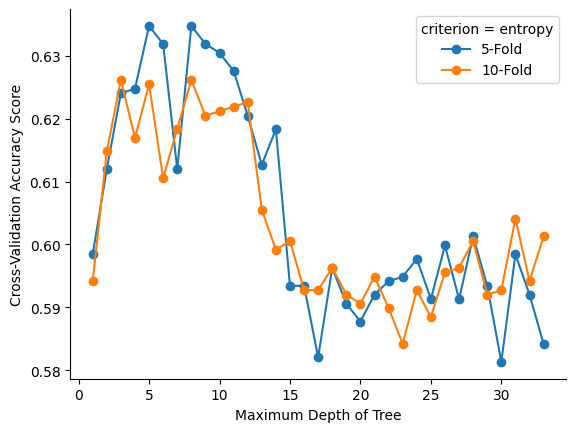

In [ ]:
plt.plot(k_values, scores5Train, label = "5-Fold", marker = 'o')
plt.plot(k_values, scores10Train, label = "10-Fold", marker = 'o')
plt.xlabel("Maximum Depth of Tree")
plt.ylabel("Cross-Validation Accuracy Score")
#plt.legend(title='criterion = entropy', loc='upper right')
plt.legend(loc='upper right', title='criterion = entropy')
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [ ]:
# calculate correlation coefficient
from scipy.stats import pearsonr
corr_k5, _ = pearsonr(k_values, scores5Train)
corr_k10, _ = pearsonr(k_values, scores10Train)
print('Pearsons correlation for cv=5: %.2f' % corr_k5)
print('Pearsons correlation for cv=10: %.2f' % corr_k10)

Pearsons correlation for cv=5: -0.73
Pearsons correlation for cv=10: -0.68


In [ ]:
# find best max_depth value
best_index5_train = np.argmax(scores5Train)
best_k5_train = k_values[best_index5_train]
print('Best k value on train set for cv=5 is', best_k5_train)

best_index10_train = np.argmax(scores10Train)
best_k10_train = k_values[best_index10_train]
print('Best k value on train set for cv=10 is', best_k10_train)

Best k value on train set for cv=5 is 8
Best k value on train set for cv=10 is 3


In [ ]:
dtc = [
    DecisionTreeClassifier(criterion='entropy', max_depth=8),
    DecisionTreeClassifier(criterion='entropy', max_depth=3)
  ]
dtc_columns = []
dtc_compare = pd.DataFrame(columns = dtc_columns)

row_index = 0
for alg in dtc:
    predicted = alg.fit(X_train, y_train).predict(X_test)
    fp, tp, th = roc_curve(y_test, predicted)
    dtc_name = alg.__class__.__name__
    dtc_compare.loc[row_index, 'Depth of Tree'] = alg.get_depth()
    dtc_compare.loc[row_index, 'Train Accuracy'] = round(alg.score(X_train, y_train), 5)
    dtc_compare.loc[row_index, 'Test Accuracy'] = round(alg.score(X_test, y_test), 5)
    dtc_compare.loc[row_index, 'Precision'] = round(precision_score(y_test, predicted),5)
    dtc_compare.loc[row_index, 'Recall'] = round(recall_score(y_test, predicted),5)
    dtc_compare.loc[row_index, 'AUC'] = round(auc(fp, tp),5)

    row_index+=1

dtc_compare

,Depth of Tree,Train Accuracy,Test Accuracy,Precision,Recall,AUC
0,8.0,0.77896,0.63245,0.58857,0.40711,0.60099
1,3.0,0.66738,0.64404,0.74359,0.22925,0.58613
